In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# ============================================
# Step 1: Load CIFAR-10 (resized to 224x224 for ResNet)
# ============================================

# ResNet expects 224x224 images with ImageNet normalization
train_transform = transforms.Compose([
    transforms.Resize(224),                              # ResNet expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=8),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),         # ImageNet mean
                         (0.229, 0.224, 0.225))          # ImageNet std
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Smaller batch size because 224x224 images use more memory
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

# ============================================
# Step 2: Helper function for training
# ============================================
def train_model(model, train_loader, test_loader, criterion, optimizer,
                scheduler=None, num_epochs=10, model_name="Model"):

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    best_test_acc = 0.0

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Evaluation
        model.eval()
        running_test_loss, correct_test, total_test = 0.0, 0, 0

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                running_test_loss += loss.item() * batch_X.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += batch_y.size(0)
                correct_test += (predicted == batch_y).sum().item()

        test_loss = running_test_loss / total_test
        test_acc = correct_test / total_test

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        if scheduler:
            scheduler.step(test_loss)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")

        print(f"Epoch {epoch+1:2d}/{num_epochs} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Train Loss: {train_loss:.4f}")

    elapsed = time.time() - start_time
    print(f"\n{model_name} — Best Test Acc: {best_test_acc:.4f} | Time: {elapsed:.1f}s")

    return train_losses, test_losses, train_accs, test_accs, best_test_acc

# ============================================
# Step 3: Approach 1 — Feature Extraction (Freeze all, train classifier only)
# ============================================
print("=" * 60)
print("APPROACH 1: Feature Extraction (Frozen backbone)")
print("=" * 60)

model_fe = models.resnet18(weights='IMAGENET1K_V1')  # load pretrained

# Freeze ALL layers
for param in model_fe.parameters():
    param.requires_grad = False

# Replace final classification layer (ResNet's fc layer outputs 1000 classes)
# We need 10 classes for CIFAR-10
num_features = model_fe.fc.in_features   # 512 for ResNet18
model_fe.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 10)
)

model_fe = model_fe.to(device)

# Count trainable parameters
total_params = sum(p.numel() for p in model_fe.parameters())
trainable_params = sum(p.numel() for p in model_fe.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")

criterion = nn.CrossEntropyLoss()
optimizer_fe = optim.Adam(model_fe.fc.parameters(), lr=0.001)  # only optimize fc layer

fe_results = train_model(model_fe, train_loader, test_loader, criterion,
                         optimizer_fe, num_epochs=10, model_name="feature_extraction")

Using: cuda


100%|██████████| 170M/170M [00:03<00:00, 44.5MB/s]


Train: 50000, Test: 10000
Image shape: torch.Size([3, 224, 224])
APPROACH 1: Feature Extraction (Frozen backbone)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


Total params: 11,310,410
Trainable params: 133,898 (1.2%)
Epoch  1/10 | Train Acc: 0.7146 | Test Acc: 0.7834 | Train Loss: 0.8329
Epoch  2/10 | Train Acc: 0.7566 | Test Acc: 0.7816 | Train Loss: 0.7028
Epoch  3/10 | Train Acc: 0.7664 | Test Acc: 0.7946 | Train Loss: 0.6767
Epoch  4/10 | Train Acc: 0.7709 | Test Acc: 0.7927 | Train Loss: 0.6649
Epoch  5/10 | Train Acc: 0.7750 | Test Acc: 0.7972 | Train Loss: 0.6535
Epoch  6/10 | Train Acc: 0.7777 | Test Acc: 0.7973 | Train Loss: 0.6427
Epoch  7/10 | Train Acc: 0.7839 | Test Acc: 0.8074 | Train Loss: 0.6234
Epoch  8/10 | Train Acc: 0.7845 | Test Acc: 0.8061 | Train Loss: 0.6210
Epoch  9/10 | Train Acc: 0.7888 | Test Acc: 0.8091 | Train Loss: 0.6150
Epoch 10/10 | Train Acc: 0.7923 | Test Acc: 0.8094 | Train Loss: 0.6047

feature_extraction — Best Test Acc: 0.8094 | Time: 1512.2s


In [3]:
# ============================================
# Step 4: Approach 2 — Fine-tuning (Unfreeze later layers)
# ============================================
print("\n" + "=" * 60)
print("APPROACH 2: Fine-tuning (Unfreeze later layers)")
print("=" * 60)

model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Freeze early layers (layer1, layer2)
for name, param in model_ft.named_parameters():
    if 'layer3' not in name and 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

# Replace final layer
num_features = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 10)
)

model_ft = model_ft.to(device)

trainable_params_ft = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Trainable params: {trainable_params_ft:,} ({trainable_params_ft/total_params*100:.1f}%)")

# Use different learning rates: smaller for pretrained layers, larger for new layers
optimizer_ft = optim.Adam([
    {'params': model_ft.layer3.parameters(), 'lr': 0.0001},    # pretrained — small lr
    {'params': model_ft.layer4.parameters(), 'lr': 0.0001},    # pretrained — small lr
    {'params': model_ft.fc.parameters(), 'lr': 0.001}          # new layer — normal lr
])

scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', patience=3, factor=0.5)

ft_results = train_model(model_ft, train_loader, test_loader, criterion,
                         optimizer_ft, scheduler_ft, num_epochs=10, model_name="fine_tuning")


APPROACH 2: Fine-tuning (Unfreeze later layers)
Trainable params: 10,627,338 (94.0%)
Epoch  1/10 | Train Acc: 0.8659 | Test Acc: 0.9089 | Train Loss: 0.4041
Epoch  2/10 | Train Acc: 0.9228 | Test Acc: 0.9313 | Train Loss: 0.2360
Epoch  3/10 | Train Acc: 0.9392 | Test Acc: 0.9296 | Train Loss: 0.1848
Epoch  4/10 | Train Acc: 0.9495 | Test Acc: 0.9310 | Train Loss: 0.1548
Epoch  5/10 | Train Acc: 0.9564 | Test Acc: 0.9378 | Train Loss: 0.1343
Epoch  6/10 | Train Acc: 0.9634 | Test Acc: 0.9417 | Train Loss: 0.1176
Epoch  7/10 | Train Acc: 0.9669 | Test Acc: 0.9423 | Train Loss: 0.1062
Epoch  8/10 | Train Acc: 0.9713 | Test Acc: 0.9422 | Train Loss: 0.0919
Epoch  9/10 | Train Acc: 0.9731 | Test Acc: 0.9410 | Train Loss: 0.0834
Epoch 10/10 | Train Acc: 0.9752 | Test Acc: 0.9427 | Train Loss: 0.0788

fine_tuning — Best Test Acc: 0.9427 | Time: 1800.2s


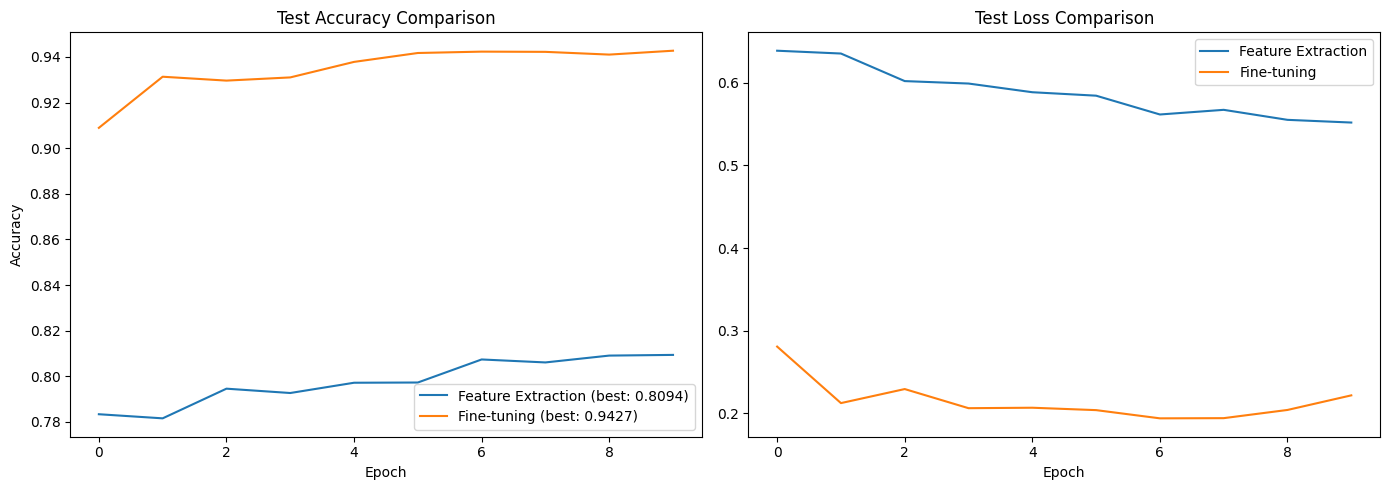


COMPARISON SUMMARY
Feature Extraction: 0.8094 (only classifier trained)
Fine-tuning:        0.9427 (later layers + classifier trained)
Project 4 CNN:      ~0.85   (trained from scratch)

Classification Report (Fine-tuned ResNet18):
              precision    recall  f1-score   support

    Airplane       0.96      0.95      0.96      1000
  Automobile       0.96      0.96      0.96      1000
        Bird       0.93      0.94      0.93      1000
         Cat       0.92      0.84      0.88      1000
        Deer       0.96      0.93      0.94      1000
         Dog       0.88      0.93      0.90      1000
        Frog       0.92      0.98      0.95      1000
       Horse       0.98      0.96      0.97      1000
        Ship       0.96      0.97      0.96      1000
       Truck       0.97      0.96      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



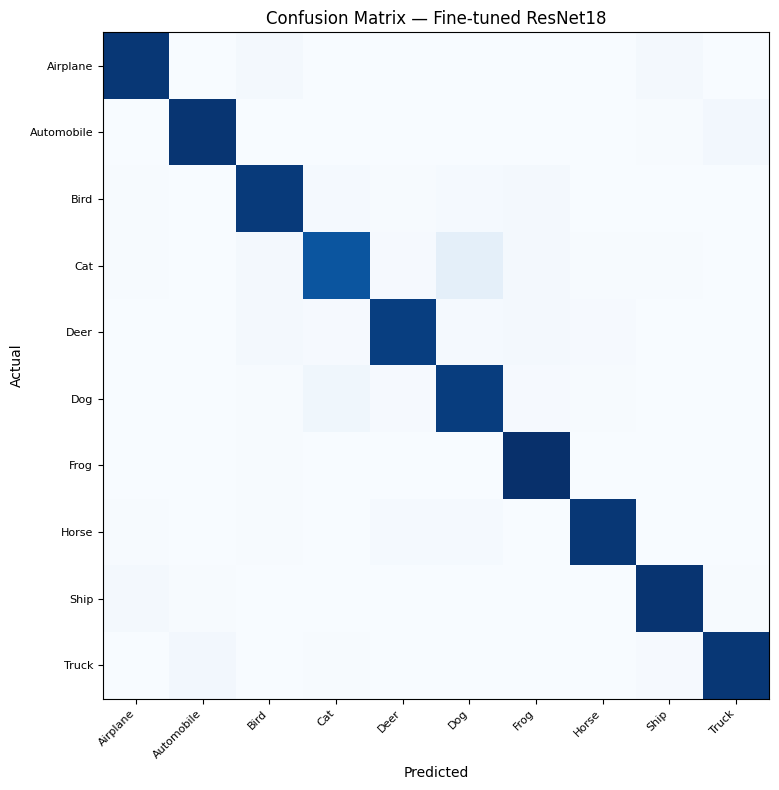


Per-Class Accuracy:
  Airplane    : 0.9550
  Automobile  : 0.9620
  Bird        : 0.9430
  Cat         : 0.8440
  Deer        : 0.9270
  Dog         : 0.9320
  Frog        : 0.9840
  Horse       : 0.9570
  Ship        : 0.9670
  Truck       : 0.9560

Model saved!


In [4]:
# ============================================
# Step 5: Compare All Approaches
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].plot(fe_results[3], label=f"Feature Extraction (best: {fe_results[4]:.4f})")
axes[0].plot(ft_results[3], label=f"Fine-tuning (best: {ft_results[4]:.4f})")
axes[0].set_title("Test Accuracy Comparison")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Loss comparison
axes[1].plot(fe_results[1], label="Feature Extraction")
axes[1].plot(ft_results[1], label="Fine-tuning")
axes[1].set_title("Test Loss Comparison")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(f"Feature Extraction: {fe_results[4]:.4f} (only classifier trained)")
print(f"Fine-tuning:        {ft_results[4]:.4f} (later layers + classifier trained)")
print(f"Project 4 CNN:      ~0.85   (trained from scratch)")

# ============================================
# Step 6: Detailed evaluation of best model
# ============================================
best_model = model_ft  # fine-tuning usually wins
best_model.load_state_dict(torch.load("best_fine_tuning.pth"))
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = best_model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

print("\nClassification Report (Fine-tuned ResNet18):")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xticklabels(class_names, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(class_names, fontsize=8)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix — Fine-tuned ResNet18")
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, name in enumerate(class_names):
    class_mask = np.array(all_labels) == i
    class_acc = (np.array(all_preds)[class_mask] == i).mean()
    print(f"  {name:12s}: {class_acc:.4f}")

# Save final model
torch.save(best_model.state_dict(), "resnet18_cifar10_finetuned.pth")
print("\nModel saved!")

